In [3]:
import seaborn as sns
import pandas as pd
import pylab as plt
import numpy as np
from steam import WebAPI
import time
import os
import glob
import json
import tensorflow as tf
import sys
from IPython import display
import requests
#dont keep api key in github!!!
api_file = os.path.join('..','..','apikeys','steam_api_key.txt')
with open(api_file, 'r') as fin:
    api = WebAPI(key=fin.readline())

tf.logging.set_verbosity(tf.logging.ERROR)

In [4]:
#declare interface urls
#dota2_beta should be used for testing in order to not aggressively make API requests
dota2_id = '570'
dota2_beta_id = '205790'

hero_list = api.call('IEconDOTA2_'+dota2_id+'.GetHeroes',itemizedonly = True)
hero_vocab=[int(hero_id['id']) for hero_id in hero_list['result']['heroes']] 

# Import training data and preprocess 
(good to check data, but not needed for TFrecord usage

In [2]:
dota2_df = None
for filename in glob.glob(os.path.join('dota2_training_data','*.csv')):
    if type(dota2_df)==None:
        dota2_df = pd.read_csv(filename, usecols=range(1,13))
    else:
        dota2_df = pd.concat([dota2_df, pd.read_csv(filename, usecols=range(1,13))],ignore_index=True)

dota2_df = dota2_df.reindex(np.random.permutation(dota2_df.index))
dota2_df.describe()


AttributeError: 'NoneType' object has no attribute 'reindex'

# Modeling using a TFRecord dataformat

## Build TFRecord input pipeline

In [5]:
def _parse_function(record):
    """Extracts features and labels.
  
    Args:
        record: File path to a TFRecord file    
      Returns:
    A `tuple` `(labels, features)`:
      features: A dict of tensors representing the features
      labels: A tensor with the corresponding labels.
    """
    features = {
        "radiant_heroes": tf.FixedLenFeature([], dtype=tf.string), #array of five 8 bit ints for heroes
        "dire_heroes": tf.FixedLenFeature([], dtype=tf.string), #array of five 8-bit ints for heroes
        "targets": tf.FixedLenFeature(shape=[1], dtype=tf.int64)
                }
  
    parsed_features = tf.parse_single_example(record, features)
  
    radiant_heroes = tf.decode_raw(parsed_features['radiant_heroes'], tf.int64)
    dire_heroes = tf.decode_raw(parsed_features['dire_heroes'], tf.int64)
    radiant_win = parsed_features['targets']

    return  {'radiant_heroes':radiant_heroes, 'dire_heroes':dire_heroes}, radiant_win

#### Check the parse function worked

In [6]:
# Create the Dataset object.
ds = tf.data.TFRecordDataset(os.path.join('Dota_data',
                                          'mixed_skill',
                                          'dota2_training_data',
                                          'radiant_windota2_training_data.tfrecords'))
# Map features and labels with the parse function.
ds = ds.map(_parse_function)

ds

<DatasetV1Adapter shapes: ({radiant_heroes: (?,), dire_heroes: (?,)}, (1,)), types: ({radiant_heroes: tf.int64, dire_heroes: tf.int64}, tf.int64)>

In [7]:
n = ds.make_one_shot_iterator().get_next()
sess = tf.Session()
sess.run(n)

({'radiant_heroes': array([11, 75, 28, 89, 94]),
  'dire_heroes': array([26, 14, 93, 56, 59])},
 array([0]))

## Model Functions

In [8]:
# Create an input_fn that parses the tf.Examples from the given files,
# and split them into features and targets.
def _input_fn(input_filenames, num_epochs=None, shuffle=True, batch_size=50):
   
  # Same code as above; create a dataset and map features and labels.
    ds = tf.data.TFRecordDataset(input_filenames)
    ds = ds.map(_parse_function)

    if shuffle:
        ds = ds.shuffle(10000)

    # Our feature data is variable-length, so we pad and batch
    # each field of the dataset structure to whatever size is necessary.
    ds = ds.padded_batch(batch_size, ds.output_shapes)
  
    ds = ds.repeat(num_epochs)
  
    # Return the next batch of data.
    features, labels = ds.make_one_shot_iterator().get_next()
    return features, labels

## Linear model with explicit vocabulary (all heroes)

In [9]:
def construct_hero_categorical_columns(keys, vocab):
    """Construct categorical features for all features
        Args: 
            input_features: names of input feature columns to use
        returns:
            a set of categorical columns
    """
    return set([tf.feature_column.categorical_column_with_vocabulary_list(key,
                                                                     vocabulary_list = vocab,
                                                                     num_oov_buckets =0)
                                    for key in keys])
                                                               

## Define and train the linear model

In [15]:
def train_linear_model(
    learning_rate,
    steps,
    batch_size,
    feature_columns,
    training_file,
    validation_file):
    """Trains a linear regression model.
  
    In addition to training, this function also prints training progress information,
    as well as a plot of the training and validation loss over time.
      
    Args:
        learning_rate: A `float`, the learning rate.
        steps: A non-zero `int`, the total number of training steps. A training step
          consists of a forward and backward pass using a single batch.
        feature_columns: A `set` specifying the input feature columns to use.
        training_examples: A `DataFrame` containing one or more columns from
          `dota2_df` to use as input features for training.
        training_targets: A `DataFrame` containing exactly one column from
          `dota2_df` to use as target for training.
      
    Returns:
        A `LinearClassifier` object trained on the training data.
    """

    periods = 20
    steps_per_period = steps / periods

    # Create a linear regressor object.
    my_optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
    my_optimizer = tf.contrib.estimator.clip_gradients_by_norm(my_optimizer, 5.0)
    linear_classifier = tf.estimator.LinearClassifier(
      feature_columns=feature_columns,
      optimizer=my_optimizer,
      config=tf.estimator.RunConfig(keep_checkpoint_max=1)
      )
  
    training_input_fn =lambda: _input_fn([training_file])
    validation_input_fn =lambda: _input_fn([validation_file])

    # Train the model, but do so inside a loop so that we can periodically assess
    # loss metrics.
    print("Training model...")
    
    
    training_loss = []
    validation_loss = []
    for i in range(periods):
        # Train the model, starting from the prior state.
        linear_classifier.train(
            input_fn=training_input_fn,
            steps=steps_per_period)
        
        # Take a break and compute predictions.
        evaluation_metrics = linear_classifier.evaluate(
            input_fn=training_input_fn,
            steps=steps_per_period)
        training_loss.append(evaluation_metrics['loss'])
                            
        evaluation_metrics = linear_classifier.evaluate(
            input_fn=validation_input_fn,
            steps=steps_per_period)    
        validation_loss.append(evaluation_metrics['loss'])
        
        print('validation loss', evaluation_metrics['loss'])

    print("validation set metrics:")
    for m in evaluation_metrics:
        print(m, evaluation_metrics[m])
    print("---")
    
    plt.plot(training_loss,label='Training loss')
    plt.plot(validation_loss,label='validation loss')
    plt.legend()
    plt.show()
    
    return linear_classifier



For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.

Training model...
validation loss 34.64777
validation loss 34.636368
validation loss 34.636456
validation loss 34.627655
validation loss 34.623646
validation loss 34.61898
validation loss 34.622025
validation loss 34.616478
validation loss 34.617165
validation loss 34.612583
validation loss 34.61464
validation loss 34.609467
validation loss 34.60234
validation loss 34.604523
validation loss 34.60161
validation loss 34.605103
validation loss 34.60398
validation loss 34.60786
validation loss 34.59952
validation loss 34.60761
validation set metrics:
accuracy 0.5352
accuracy_baseline 0.5344
auc 0.52594364
auc_precision_recall 0.5953481
average_loss 0.6921522
label/mean 0.5344
loss 34.60761
precision 0.5348279
prediction/mean 0.50445837
recall 1.0
global_step

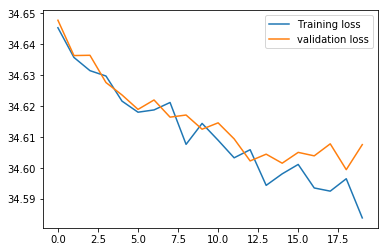

In [11]:
training_file = os.path.join('Dota_data',
                             'mixed_skill',
                             'dota2_training_data',
                             'radiant_windota2_training_data.tfrecords')
validation_file = os.path.join('Dota_data',
                             'mixed_skill',
                             'dota2_validation_data',
                             'radiant_windota2_validation_data.tfrecords')

categorical_column = construct_hero_categorical_columns(['radiant_heroes','dire_heroes'],
                                                       hero_vocab)
trained_linear_model = train_linear_model(
    learning_rate=0.0002,
    steps=1e3,
    batch_size=1000,
    feature_columns=categorical_column,
    training_file=training_file,
    validation_file=validation_file)

Training model...
validation loss 33.674496
validation loss 33.642338
validation loss 33.642105
validation loss 33.613914
validation loss 33.6549
validation loss 33.704384
validation loss 33.627647
validation loss 33.68958
validation loss 33.70687
validation loss 33.69471
validation loss 33.669468
validation loss 33.680668
validation loss 33.654728
validation loss 33.722614
validation loss 33.70331
validation loss 33.70118
validation loss 33.69193
validation loss 33.71131
validation loss 33.70861
validation loss 33.689926
validation set metrics:
accuracy 0.57964367
accuracy_baseline 0.5476635
auc 0.60015005
auc_precision_recall 0.6331728
average_loss 0.67394227
label/mean 0.5476635
loss 33.689926
precision 0.5916439
prediction/mean 0.55407506
recall 0.7503531
global_step 15000
---


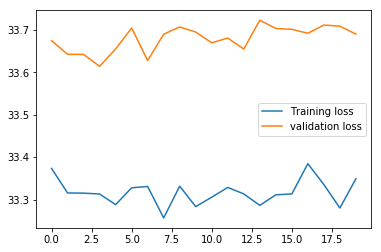

In [13]:
trained_linear_model = train_linear_model(
    learning_rate=0.05,
    steps=15e3,
    batch_size=1000,
    feature_columns=categorical_column,
    training_file=training_file,
    validation_file=validation_file)

Training model...
validation loss 34.223663
validation loss 34.09642
validation loss 33.75496
validation loss 33.9952
validation loss 33.95862
validation loss 33.711315
validation loss 33.870617
validation loss 33.642506
validation loss 33.837982
validation loss 33.990185
validation loss 33.905567
validation loss 33.828808
validation loss 33.796146
validation loss 33.729336
validation loss 34.108387
validation loss 33.649437
validation loss 33.859543
validation loss 33.278732
validation loss 34.396317
validation loss 33.832203
validation set metrics:
accuracy 0.5812
accuracy_baseline 0.55
auc 0.5928666
auc_precision_recall 0.6149239
average_loss 0.676644
label/mean 0.55
loss 33.832203
precision 0.5992736
prediction/mean 0.54412585
recall 0.72
global_step 1000
---


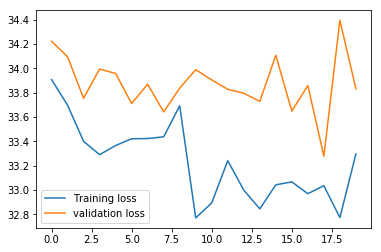

In [14]:
trained_linear_model = train_linear_model(
    learning_rate=0.05,
    steps=1e3,
    batch_size=1000,
    feature_columns=categorical_column,
    training_file=training_file,
    validation_file=validation_file)

### Validate model
only do this if you're done training!!

In [17]:
test_file = os.path.join('dota2_test_data', 'dota2_test_data.tfrecords')
test_input_fn =lambda: _input_fn([test_file])
evaluation_metrics = trained_linear_model.evaluate(
            input_fn=test_input_fn,
            steps=100)
for m in evaluation_metrics:
    print(m, evaluation_metrics[m])

accuracy 0.5852
accuracy_baseline 0.5486
auc 0.6071559
auc_precision_recall 0.6377059
average_loss 0.67106634
label/mean 0.5486
loss 33.553318
precision 0.59609306
prediction/mean 0.5435795
recall 0.75647104
global_step 1000000


## Define and train a DNN model

### Define feature column constructor functions

In [5]:
def construct_indicator_columns(feature_columns):
    """Construct indicator columns for all features
            from categorical columns
        Args: 
            feature_columns: Set of 'tf.feature_column.categorical_column'
                to convert to indicator columns
        returns:
            a list of indicator columns
    """
    indicator_columns = []
    for column in list(feature_columns):
        indicator_columns.append(tf.feature_column.indicator_column(column))
        
    return indicator_columns
        

In [6]:
def construct_embedding_columns(feature_columns, dimension):
    """Construct embedding columns for all features
            from categorical columns
        Args:
            feature_columns: `Set` of 'tf.feature_column.categorical_column'
                to convert to embedding columns
            dimension: `int` that shows the 
        returns:
            a list of embedding columns
    """
            
    embedding_columns = []
    for column in list(feature_columns):
        embedding_columns.append(tf.feature_column.embedding_column(column,dimension=dimension))
        
    return embedding_columns

### Define model training function

In [7]:
def train_dnn_model(
    my_optimizer,
    hidden_units,
    steps,
    batch_size,
    feature_columns,
    training_file,
    test_file):
    """Trains a deep neural network regression model.
  
    In addition to training, this function also prints training progress information,
    as well as a plot of the training and validation loss over time.
      
    Args:
        learning_rate: A `float`, the learning rate.
        hidden_units: A `list` of `ints` specifying the number of layers and number 
            of nodes per layer.
        steps: A non-zero `int`, the total number of training steps. A training step
          consists of a forward and backward pass using a single batch.
        feature_columns: A `set` specifying the input feature columns to use.
        training_examples: A `DataFrame` containing one or more columns from
          `dota2_df` to use as input features for training.
        training_targets: A `DataFrame` containing exactly one column from
          `dota2_df` to use as target for training.
      
    Returns:
        A `DNNClassifer` object trained on the training data.
    """

    periods = 20
    steps_per_period = steps / periods

    # Create a dnn regressor object.
    dnn_classifier = tf.estimator.DNNClassifier(
      feature_columns=feature_columns,
      hidden_units=hidden_units,
      optimizer=my_optimizer
        )
  
    training_input_fn =lambda: _input_fn([training_file],batch_size=batch_size)
    test_input_fn =lambda: _input_fn([test_file],batch_size=batch_size)

    # Train the model, but do so inside a loop so that we can periodically assess
    # loss metrics.
    print("Training model...")
    
    
    training_acc = []
    test_acc = []
    for i in range(periods):
        # Train the model, starting from the prior state.
        dnn_classifier.train(
            input_fn=training_input_fn,
            steps=steps_per_period)
        
        # Take a break and compute predictions.
        evaluation_metrics = dnn_classifier.evaluate(
            input_fn=training_input_fn,
            steps=steps_per_period)
        training_acc.append(evaluation_metrics['accuracy'])
        #print('training accuracy %f' %(evaluation_metrics['accuracy'])) 
        
        evaluation_metrics = dnn_classifier.evaluate(
            input_fn=test_input_fn,
            steps=steps_per_period)    
        test_acc.append(evaluation_metrics['accuracy'])
        
        print('test accuracy %f' %(evaluation_metrics['accuracy']))

    print("Test set metrics:")
    for m in evaluation_metrics:
        print(m, evaluation_metrics[m])
    print("---")
    
    plt.plot(training_acc,label='Training accuracy')
    plt.plot(test_acc,label='Test accuracy')
    plt.plot(evaluation_metrics['accuracy_baseline']*np.ones(periods),label='Baseline accuracy')
    plt.legend()
    plt.show()
    
    return dnn_classifier


### Specify path to tfrecord files and construct feature colums

In [8]:
training_file = os.path.join('dota2_training_data','dota2_training_data.tfrecords')
test_file = os.path.join('dota2_test_data', 'dota2_test_data.tfrecords')

categorical_feature_columns = construct_hero_categorical_columns(['radiant_heroes','dire_heroes'])
indicator_feature_columns = construct_indicator_columns(categorical_feature_columns)

embed_dim = 4
embedding_feature_columns = construct_embedding_columns(categorical_feature_columns,dimension=embed_dim)

### Train model

Training model...
test accuracy 0.586736
test accuracy 0.588651
test accuracy 0.590036
test accuracy 0.590187
test accuracy 0.590589
test accuracy 0.590265
test accuracy 0.591081
test accuracy 0.590503
test accuracy 0.590707
test accuracy 0.591175
test accuracy 0.591389
test accuracy 0.591301
test accuracy 0.591562
test accuracy 0.591605
test accuracy 0.591484
test accuracy 0.591186
test accuracy 0.591440
test accuracy 0.591188
test accuracy 0.591394
test accuracy 0.591588
Test set metrics:
accuracy 0.59158844
accuracy_baseline 0.5452399
auc 0.6168599
auc_precision_recall 0.64596987
average_loss 0.6678934
label/mean 0.5452399
loss 1992.6101
precision 0.5989614
prediction/mean 0.5533037
recall 0.7594368
global_step 30000
---


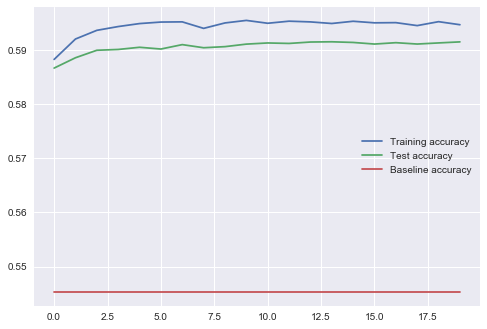

In [9]:
my_optimizer = tf.contrib.opt.AdamWOptimizer(weight_decay=0.0004, learning_rate=0.0025)
#my_optimizer = tf.contrib.estimator.clip_gradients_by_norm(my_optimizer, 5.0)

dnn_hidden_units = [10,10]
dnn_steps = 3e4
dnn_batch_size = 3000
trained_dnn_model = train_dnn_model(
    my_optimizer = my_optimizer,
    hidden_units = dnn_hidden_units,
    steps = dnn_steps,
    batch_size = dnn_batch_size,
    feature_columns=embedding_feature_columns,
    training_file=training_file,
    test_file=test_file)

### Validate model
only do this if you're done training!!

In [10]:
validation_file = os.path.join('dota2_validation_data', 'dota2_validation_data.tfrecords')
validation_input_fn =lambda: _input_fn([validation_file])
evaluation_metrics = trained_dnn_model.evaluate(
            input_fn=validation_input_fn,
            steps=3e4)
for m in evaluation_metrics:
    print(m, evaluation_metrics[m])

accuracy 0.5890347
accuracy_baseline 0.543492
auc 0.6158235
auc_precision_recall 0.64411813
average_loss 0.6686505
label/mean 0.543492
loss 33.432526
precision 0.59568346
prediction/mean 0.5534632
recall 0.75902987
global_step 30000


### Investigate embeding layer

In [79]:
hero_list = interface('IEconDOTA2_570').GetHeroes(itemizedonly = True)['result']['heroes']

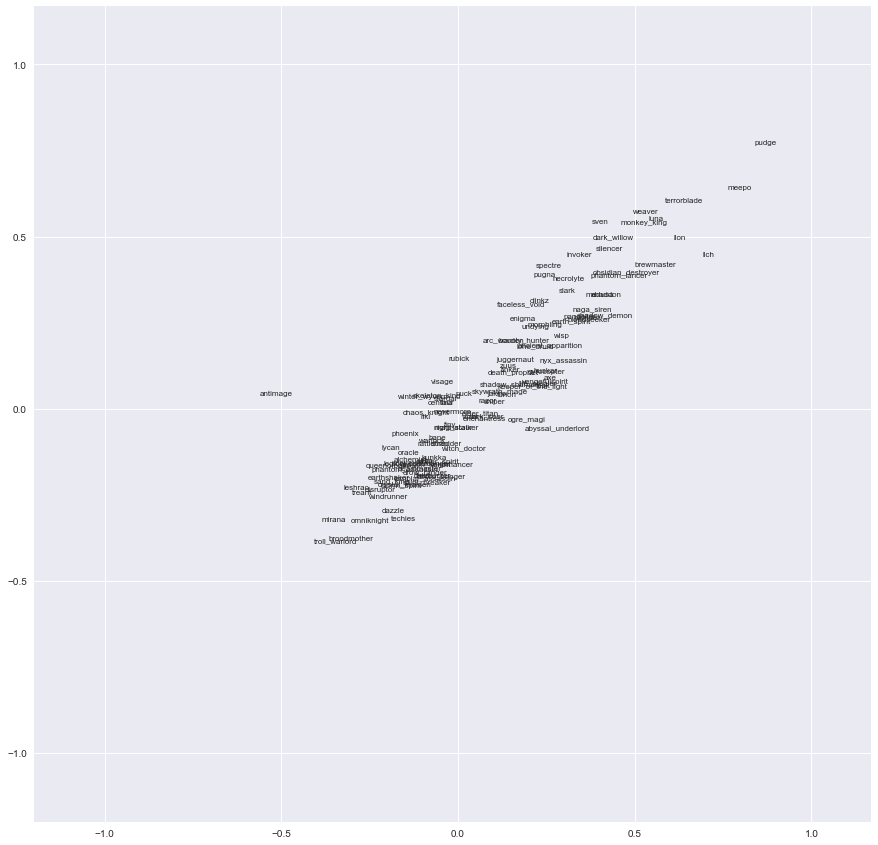

In [85]:
vocab = list(range(105))+list(range(106,114))+list(range(119,121))
dire_embedding_matrix = trained_dnn_model.get_variable_value(
    'dnn/input_from_feature_columns/input_layer/dire_heroes_embedding/embedding_weights')

radiant_embedding_matrix = trained_dnn_model.get_variable_value(
    'dnn/input_from_feature_columns/input_layer/radiant_heroes_embedding/embedding_weights')

for hero_index in range(len(vocab)):
    # Create a one-hot encoding for our term. It has 0s everywhere, except for
    # a single 1 in the coordinate that corresponds to that term.
    dire_vector = np.zeros(len(vocab))
    dire_vector[hero_index] = 1
    radiant_vector = np.zeros(len(vocab))
    radiant_vector[hero_index] = 1
    # We'll now project that one-hot vector into the embedding space.
    dire_embedding_xy = np.matmul(dire_vector, dire_embedding_matrix)
    radiant_embedding_xy = np.matmul(dire_vector,dire_embedding_matrix)
    #plt.text(dire_embedding_xy[0],
    #       dire_embedding_xy[1],
    #       hero_list[hero_index]['name'][14:],fontsize=8)
    plt.text(radiant_embedding_xy[0],
           radiant_embedding_xy[3],
           hero_list[hero_index]['name'][14:],fontsize=8,)

# Do a little setup to make sure the plot displays nicely.
plt.rcParams["figure.figsize"] = (15, 15)
plt.xlim(1.2 * dire_embedding_matrix.min(), 1.2 * dire_embedding_matrix.max())
plt.ylim(1.2 * dire_embedding_matrix.min(), 1.2 * dire_embedding_matrix.max())
plt.show() 

### Save a trained model for later exploration, or for on-demand prediction of test cases

In [18]:
def serving_input_receiver_fn():
    """An input receiver that expects a serialized tf.Example."""
    feature_spec = {
        "radiant_heroes": tf.FixedLenFeature([], dtype=tf.string), #array of five 8 bit ints for heroes
        "dire_heroes": tf.FixedLenFeature([], dtype=tf.string) #array of five 8-bit ints for heroes
                }
    serialized_tf_example = tf.placeholder(dtype=tf.string,
                                         shape=[1],
                                         name='input_example_tensor')
    receiver_tensors = {'examples': serialized_tf_example}
    parsed_features = tf.parse_example(serialized_tf_example, feature_spec)
    
    radiant_heroes = tf.decode_raw(parsed_features['radiant_heroes'], tf.int64)
    dire_heroes = tf.decode_raw(parsed_features['dire_heroes'], tf.int64)
    
    features = {'radiant_heroes':radiant_heroes, 'dire_heroes': dire_heroes}
    
    return tf.estimator.export.ServingInputReceiver(features, receiver_tensors)

In [19]:
export_dir = os.path.join('trained_models','dnn_models')
trained_dnn_model.export_savedmodel(
                                export_dir_base = export_dir,
                                serving_input_receiver_fn = serving_input_receiver_fn)

b'trained_models/dnn_models/1554174557'

# Preprocessing, input functions, and linear training for DataFrame data format

## Preprocess functions for input without TFRecords format

In [46]:
#Split training and validation datasets with a given training fraction. 

#to begin with we have a sample of 7050 matches to validation the model with.
#This may not be enough games to accurately determine win probability but probably good enough for first validations

training_fraction = 0.7
head_num = int(training_fraction * len(dota2_df))
tail_num = len(dota2_df)-head_num

training_examples = preprocess_features(dota2_df.head(head_num))
training_targets = preprocess_targets(dota2_df.head(head_num))

validation_examples = preprocess_features(dota2_df.tail(tail_num))
validation_targets = preprocess_targets(dota2_df.tail(tail_num))

#print("Training features summary")
#training_examples.style
print("\nTraining targets summary")
display.display(training_targets.describe())

#print("\nvalidation feature summary")
#validation_examples.style
print("\nvalidation target summary")
display.display(validation_targets.describe())


Training targets summary


,radiant_win
count,6157.000000
mean,0.549943
std,0.497540
min,0.000000
25%,0.000000
50%,1.000000
75%,1.000000
max,1.000000



validation target summary


,radiant_win
count,2640.000000
mean,0.549242
std,0.497664
min,0.000000
25%,0.000000
50%,1.000000
75%,1.000000
max,1.000000


In [3]:
def preprocess_features(dota2_df):
    """Take dota2_df and create a dataframe containing only the features for our model
            Args: 
                dota2_df: Dataframe containing dota2 training and test data
            returns: 
                processed_df: pandas DataFrame containing only feature columns
    """
    
    #Use arrays of heroes for each team as features rather than each hero
    #individually to help model fit?
    #This is an attempt to make the model more similar to the movie review
    #text analysis example in the Google ML Crash Course
    processed_df = pd.DataFrame()
    
    processed_df['radiant_heroes'] = list(np.array(dota2_df.loc[:,['radiant_heroes0',
                                                'radiant_heroes1','radiant_heroes2',
                                                'radiant_heroes3','radiant_heroes4']]))
    processed_df['dire_heroes'] = list(np.array(dota2_df.loc[:,['dire_heroes0',
                                    'dire_heroes1','dire_heroes2',
                                    'dire_heroes3','dire_heroes4']]))
    
    ##only features (to start with) are the heroes in the game
    #processed_df = dota2_df[['radiant_heroes0', 'radiant_heroes1',
    #                   'radiant_heroes2', 'radiant_heroes3', 'radiant_heroes4',
    #                    'dire_heroes0', 'dire_heroes1', 'dire_heroes2',
    #                    'dire_heroes3', 'dire_heroes4']]
    
    ##create two synthetic features that is the product of all heroes for each team
    #processed_df['radiant_hero_product'] = dota2_df['radiant_heroes0']*dota2_df['radiant_heroes1']*dota2_df['radiant_heroes2']dota2_df['radiant_heroes3']*dota2_df['radiant_heroes4']
    #processed_df['dire_hero_product'] = dota2_df['dire_heroes0']*dota2_df['dire_heroes1']*dota2_df['dire_heroes2']dota2_df['dire_heroes3']*dota2_df['dire_heroes4']
    
    return processed_df
    
def preprocess_targets(dota2_df):
    """Take dota2_df and create a dataframe containing only the targets for our model
            Args: 
                dota2_df: Dataframe containing dota2 training and test data
            returns: 
                target_df: pandas DataFrame containing only the target column
    """
    target_df = pd.DataFrame()
    target_df['radiant_win'] = dota2_df['radiant_win']
    
    return target_df

## Build Functions for doing linear classifier modelling without TFRecords

In [77]:
def my_input_fn(features, targets, batch_size=1, shuffle=True, num_epochs=None):
    """Trains a logistic regression model.
  
    Args:
      features: pandas DataFrame of features
      targets: pandas DataFrame of targets
      batch_size: Size of batches to be passed to the model
      shuffle: True or False. Whether to shuffle the data.
      num_epochs: Number of epochs for which data should be repeated. None = repeat indefinitely
    Returns:
      Tuple of (features, labels) for next data batch
    """
    
    # Convert pandas data into a dict of np arrays.
    features = {key:np.array(value) for key,value in dict(features).items()}                                           
 
    # Construct a dataset, and configure batching/repeating.
    ds = tf.data.Dataset.from_tensor_slices((features,targets)) # warning: 2GB limit
    ds = ds.batch(batch_size).repeat(num_epochs)
    
    # Shuffle the data, if specified.
    if shuffle:
        ds = ds.shuffle(10000)
    
    # Return the next batch of data.
    features, labels = ds.make_one_shot_iterator().get_next()
    return features, labels

### DNN model training 

In [86]:
def train_dnn_model(
    learning_rate,
    regularization,
    hidden_units,
    steps,
    batch_size,
    feature_columns,
    training_examples,
    training_targets):
    """Trains a deep neural network regression model.
  
    In addition to training, this function also prints training progress information,
    as well as a plot of the training and validation loss over time.
      
    Args:
        learning_rate: A `float`, the learning rate.
        l1_regularization: A `float`, the L1 regularization rate. This regularizatin 
          penalizes non-zero weights in the model to prevent overfitting as well as
          save memory.
        l2_regularization: A `float`, the L2 regularization rate. This regularization
          penalizes large weights in the model to prevent overfitting.
        hidden_units: A list of `ints`, the number of nodes in each layer for the DNN
          model.
        steps: A non-zero `int`, the total number of training steps. A training step
          consists of a forward and backward pass using a single batch.
        feature_columns: A `set` specifying the input feature columns to use.
        training_examples: A `DataFrame` containing one or more columns from
          `dota2_df` to use as input features for training.
        training_targets: A `DataFrame` containing exactly one column from
          `dota2_df` to use as target for training.
      
    Returns:
        A `DNNClassifer` object trained on the training data.
    """

    periods = 10
    steps_per_period = steps / periods

    # Create a linear regressor object.
    my_optimizer = tf.train.AdagradOptimizer(learning_rate=learning_rate)
    my_optimizer = tf.contrib.estimator.clip_gradients_by_norm(my_optimizer, 5.0)
    dnn_classifier = tf.estimator.DNNClassifier(
      feature_columns=feature_columns,
      hidden_units=hidden_units,
      optimizer=my_optimizer
      )
  
    training_input_fn = lambda: my_input_fn(training_examples, 
                                          training_targets["radiant_win"], 
                                          batch_size=batch_size)
    predict_training_input_fn = lambda: my_input_fn(training_examples, 
                                                  training_targets["radiant_win"], 
                                                  num_epochs=1, 
                                                  shuffle=False)

    # Train the model, but do so inside a loop so that we can periodically assess
    # loss metrics.
    print("Training model...")
    print("RMSE (on training data):")
    training_rmse = []
    for period in range (0, periods):
        # Train the model, starting from the prior state.
        dnn_classifier.train(
            input_fn=training_input_fn,
            steps=steps_per_period
            )
        # Take a break and compute predictions.
        training_predictions = dnn_classifier.predict(input_fn=predict_training_input_fn)
    
    print("Model training finished.")


    return dnn_classifier

In [ ]:
trained_linear_model = train_dnn_model(
    learning_rate=0.07,
    regularization=0.01
    steps=1000,
    batch_size=100,
    feature_columns=construct_hero_categorical_columns(training_examples),
    training_examples=training_examples,
    training_targets=training_targets)